In [2]:
import pandas as pd
import numpy as np
import kagglehub

from kagglehub import KaggleDatasetAdapter

# Sklearn for splitting data
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import KFold # for cross-validation

Loading data from Kaggle using `kagglehub`

In [3]:
file_path = "House_Rent_Dataset.csv"

df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "iamsouravbanerjee/house-rent-prediction-dataset",
  file_path
)

/tmp/ipykernel_2076/958750046.py:3: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 554k/554k [00:00<00:00, 934kB/s]


In [4]:
df.head()

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


In [6]:
df.shape

(4746, 12)

In [7]:
df.dtypes

Posted On            object
BHK                   int64
Rent                  int64
Size                  int64
Floor                object
Area Type            object
Area Locality        object
City                 object
Furnishing Status    object
Tenant Preferred     object
Bathroom              int64
Point of Contact     object
dtype: object

In [8]:
df['Posted On'] = pd.to_datetime(df['Posted On'])

In [12]:
df.columns

Index(['Posted On', 'BHK', 'Rent', 'Size', 'Floor', 'Area Type',
       'Area Locality', 'City', 'Furnishing Status', 'Tenant Preferred',
       'Bathroom', 'Point of Contact'],
      dtype='object')

In [26]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [24]:
strings = list(df.dtypes[df.dtypes == 'object'].index)

In [25]:
for col in strings:
    df[col] = df[col].str.lower().str.replace(' ', '_') 

In [27]:
for col in df.columns:
    print(col)
    print(df[col].unique()[:5])
    print(df[col].nunique())
    print()

posted_on
<DatetimeArray>
['2022-05-18 00:00:00', '2022-05-13 00:00:00', '2022-05-16 00:00:00',
 '2022-07-04 00:00:00', '2022-05-09 00:00:00']
Length: 5, dtype: datetime64[ns]
81

bhk
[2 1 3 6 4]
6

rent
[10000 20000 17000  7500  7000]
243

size
[1100  800 1000  850  600]
615

floor
['ground_out_of_2' '1_out_of_3' '1_out_of_2' 'ground_out_of_1'
 'ground_out_of_4']
480

area_type
['super_area' 'carpet_area' 'built_area']
3

area_locality
['bandel' 'phool_bagan,_kankurgachi' 'salt_lake_city_sector_2'
 'dumdum_park' 'south_dum_dum']
2231

city
['kolkata' 'mumbai' 'bangalore' 'delhi' 'chennai']
6

furnishing_status
['unfurnished' 'semi-furnished' 'furnished']
3

tenant_preferred
['bachelors/family' 'bachelors' 'family']
3

bathroom
[2 1 3 5 4]
8

point_of_contact
['contact_owner' 'contact_agent' 'contact_builder']
3



In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<Axes: xlabel='rent', ylabel='Count'>

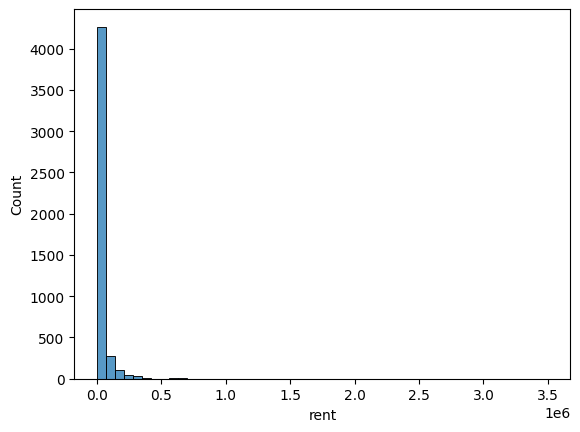

In [30]:
sns.histplot(df.rent, bins=50)

<Axes: xlabel='rent', ylabel='Count'>

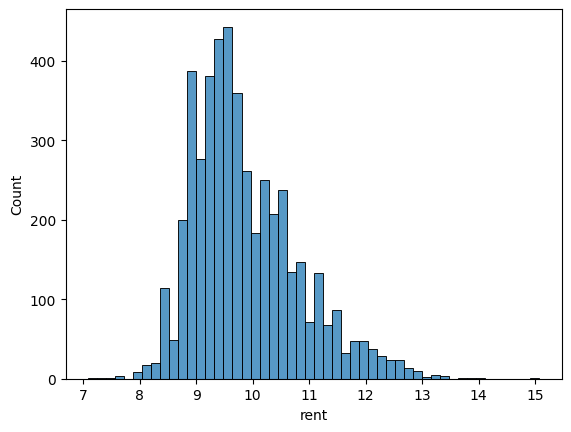

In [31]:
price_logs = np.log1p(df.rent)
sns.histplot(price_logs, bins=50)

Missing Values

In [32]:
df.isnull().sum()

posted_on            0
bhk                  0
rent                 0
size                 0
floor                0
area_type            0
area_locality        0
city                 0
furnishing_status    0
tenant_preferred     0
bathroom             0
point_of_contact     0
dtype: int64

In [34]:
df.describe().round(2)

,posted_on,bhk,rent,size,bathroom
count,4746,4746.00,4746.00,4746.00,4746.00
mean,2022-06-07 18:01:40.126422272,2.08,34993.45,967.49,1.97
min,2022-04-13 00:00:00,1.00,1200.00,10.00,1.00
25%,2022-05-20 00:00:00,2.00,10000.00,550.00,1.00
50%,2022-06-10 00:00:00,2.00,16000.00,850.00,2.00
75%,2022-06-28 00:00:00,3.00,33000.00,1200.00,2.00
max,2022-07-11 00:00:00,6.00,3500000.00,8000.00,10.00
std,NaN,0.83,78106.41,634.20,0.88


Spliting data

In [36]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.rent.values
y_val = df_val.rent.values
y_test = df_test.rent.values

del df_train['rent']
del df_val['rent']
del df_test['rent']

In [37]:
len(df_train), len(df_val), len(df_test)

(2847, 949, 950)

In [43]:
# Numerical columns (contain numeric values)
numerical = [
    'bhk',        # Number of Bedrooms, Hall, Kitchen
    'size',       # Size of the property in square feet
    'bathroom'    # Number of bathrooms
]

# Categorical columns (contain text or descriptive values)
categorical = [
    'posted_on',         # Date when the property was listed
    'floor',             # Example: "Ground out of 2", "3 out of 5"
    'area_type',         # Super Area / Carpet Area / Build Area
    'area_locality',     # Locality of the property
    'city',              # City where the property is located
    'furnishing_status', # Furnished / Semi-Furnished / Unfurnished
    'tenant_preferred',  # Type of tenant preferred
    'point_of_contact'   # Who to contact for more information
]


In [40]:
df_train.iloc[10]

posted_on            2022-06-02 00:00:00
bhk                                    1
size                                 600
floor                         1_out_of_4
area_type                    carpet_area
area_locality                     hebbal
city                           bangalore
furnishing_status            unfurnished
tenant_preferred               bachelors
bathroom                               2
point_of_contact           contact_owner
Name: 10, dtype: object

In [44]:
from sklearn.feature_extraction import DictVectorizer

In [46]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

TypeError: Unsupported value Type <class 'pandas._libs.tslibs.timestamps.Timestamp'> for posted_on: 2022-06-15 00:00:00.
<class 'pandas._libs.tslibs.timestamps.Timestamp'> objects are not supported.